# Introduction

This notebook builds off of `cora_graph_embs.ipynb`.  In this section, we will use `optuna` to tune the hyperparamters of the `FastRP` algorithm to optimize for accuracy on this multi-class problem.

For more information on `optuna`, please see the [optuna documentation](https://optuna.readthedocs.io/en/stable/).

_It is necessary to have the database populated prior to running this notebook._

### Note: This next line is required if you are running this notebook on Google Colab.

In [ ]:
!pip install neo4j
!pip install optuna

In [2]:
%matplotlib inline

import ast

from neo4j import GraphDatabase

import numpy as np
import pandas as pd

import optuna

from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [3]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [4]:
uri = ''
pwd = ''

conn = Neo4jConnection(uri=uri, user="neo4j", pwd=pwd)

conn.query("MATCH (n) RETURN COUNT(n)")

[<Record COUNT(n)=2708>]

In [16]:
def create_X_y():

    query = """MATCH (p:Paper) RETURN p.id AS id, p.subject AS subject, p.fastrp_embedding AS fastrp_embedding"""
    emb_df = pd.DataFrame([dict(_) for _ in conn.query(query)])
    emb_df['target'] = pd.factorize(emb_df['subject'])[0].astype("float32")
    y = emb_df['target'].to_numpy()
    emb_df['X'] = emb_df['fastrp_embedding'].apply(lambda x: np.array(x))
    X = np.array(emb_df['X'].to_list())

    return X, y


def modeler(params):

    acc_scores = []
    k_folds = 5

    # create_embs(dim=dim)
    X, y = create_X_y()

    for i in range(0, k_folds):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        clf = svm.SVC(kernel='linear', class_weight='balanced')
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        acc = accuracy_score(pred, y_test)
        acc_scores.append(acc)        

    return np.mean(acc_scores)

In [33]:
def objectiveSKLearn():
    
    def objective(params):

        dim = params['embeddingDimension']
        thirdWeight = params['thirdWeight']
        fourthWeight = params['fourthWeight']
        normalizationStrength = params['normalizationStrength']

        # Create embeddings
        query = """CALL gds.fastRP.write(
                    'cora',
                    {
                        embeddingDimension: %d,
                        iterationWeights: [0.0, 0.0, %f, %f],
                        normalizationStrength: %f,
                        randomSeed: 42,
                        writeProperty: 'fastrp_embedding'
                    }
                )
        """ % (dim, thirdWeight, fourthWeight, normalizationStrength)

        conn.query(query)

        return modeler(params)
    
    return objective

In [32]:
def optuna_objective(trial):

    params = {
        'embeddingDimension': trial.suggest_int('embeddingDimension', 32, 512, log=True),
        'thirdWeight': trial.suggest_float('thirdWeight', 0.0, 1.0),
        'fourthWeight': trial.suggest_float('fourthWeight', 0.0, 1.0),
        'normalizationStrength': trial.suggest_float('normalizationStrength', -1.0, 1.0)
    }

    return objective(params)


In [37]:
objective = objectiveSKLearn()

initial_params = {
    'embeddingDimension': 64,
    'thirdWeight': 0.5,
    'fourthWeight': 1.0,
    'normalizationStrength': -0.5
    
}

study = optuna.create_study(direction='maximize')
study.enqueue_trial(initial_params)
study.optimize(optuna_objective, n_trials=100)

[I 2021-10-25 18:11:07,305] A new study created in memory with name: no-name-9dfc8aec-ef26-4344-ad28-b9832877e215
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ExperimentalWarning:

enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.

/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:857: ExperimentalWarning:

create_trial is experimental (supported from v2.0.0). The interface can change in the future.

/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:857: ExperimentalWarning:

add_trial is experimental (supported from v2.0.0). The interface can change in the future.

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:364: FutureWarning:

Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.

[I 2021-10-25 18:

In [38]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [39]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [40]:
def create_embs(embeddingDimension, thirdWeight, fourthWeight, normalizationStrength):

        # Create embeddings
        query = """CALL gds.fastRP.write(
                    'cora',
                    {
                        embeddingDimension: %d,
                        iterationWeights: [0.0, 0.0, %f, %f],
                        normalizationStrength: %f,
                        randomSeed: 42,
                        writeProperty: 'fastrp_embedding'
                    }
                )
        """ % (embeddingDimension, thirdWeight, fourthWeight, normalizationStrength)

        conn.query(query)


def create_tsne_plot(emb_name='fastrp_embedding'):

    create_embs(embeddingDimension=411, thirdWeight=1.0, fourthWeight=0.893, normalizationStrength=0.823)
    X, y = create_X_y()

    X_emb = TSNE(n_components=2).fit_transform(X)

    tsne_df = pd.DataFrame(data = {
        'x': [value[0] for value in X_emb],
        'y': [value[1] for value in X_emb], 
        'label': y
    })

    plt.figure(figsize=(16,10))
    s = 30
    ax = sns.scatterplot(
        x='x', y='y',
        palette=sns.color_palette('hls', 7),
        data=tsne_df,
        hue='label',
        legend=True, 
        s=100,
        alpha=0.75
    )
    ax.legend(prop={'size': 10})
    plt.xlabel('X Component', fontsize=16)
    plt.ylabel('Y Component', fontsize=16)
    plt.show
    
    return tsne_df

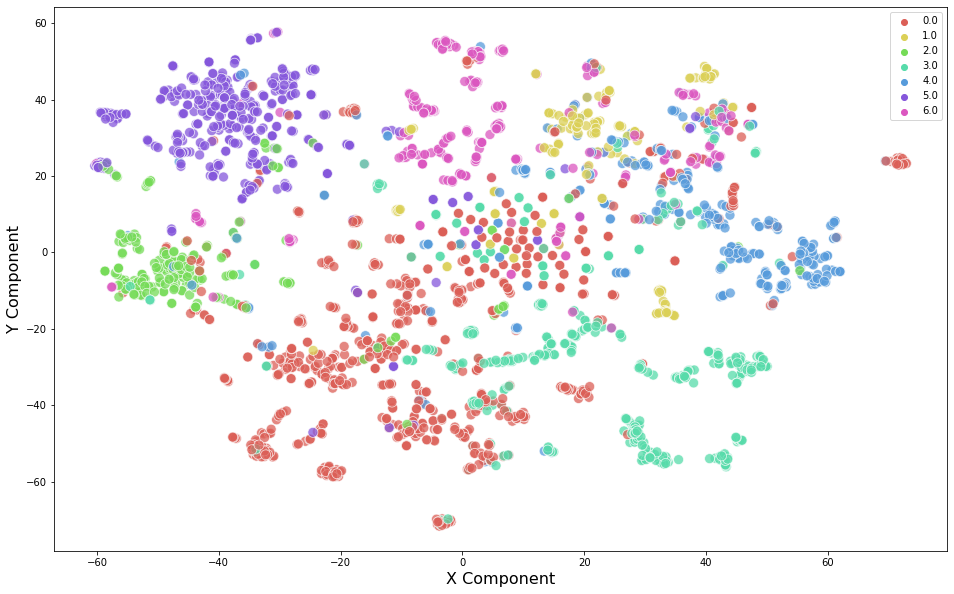

In [41]:
tsne_df = create_tsne_plot()